## IOT Pipeline with Azure Stream Analytics and DataBricks

This notebook is meant to be executed in Databricks. For on-premise Spark clusters, a spark session has to be created first with code below:
```
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
```

This notebook incrementally process json files generated by iot devices, transform the data and write them back to data lake as parquet files. An illustration of time-series forcast is also provided.
All the azure setup followed the tutorial provided by Microsoft in the following link except the Azure Stream Analytics job.
https://docs.microsoft.com/en-us/azure/stream-analytics/stream-analytics-quick-create-portal
For the Azure Stream Analytics job, the input setup is the same. The output path is set up as `{partitionId}/{datetime:yyyy}/{datetime:MM}/{datetime:dd}` so that data from different device each day are stream into different folders as below:
<img src="images/output.jpg">
The query process the data in a small time window in real-time to filter out excessive data in order to reduce data size.
<img src="images/query.jpg">

### Step 1: Set the data location and type

There are two ways to access Azure Blob storage: account keys and shared access signatures (SAS).

In this case, we use the SAS method.

In [0]:
# This is the only way I managed to install fbprophet library
%pip install pystan==2.18.0.0
%pip install fbprophet

In [0]:
import pandas as pd
from fbprophet import Prophet
from pyspark.sql import *
from pyspark.sql.functions import *
import logging 
# I did this to get rid of some annoying messages
logging.getLogger("py4j").setLevel(logging.ERROR)

In [0]:
# Make sure you fill in your own credentials
storage_account_name = ""
blob_container = ""
storage_account_access_key = ""

For batch processing, data for each device is processed after mid-night, so the data is stored in the folder previous day

In [0]:
from datetime import datetime, timedelta
t = datetime.utcnow() - timedelta(days=1)
deviceId = 3
input_location = f"wasbs://{blob_container}@{storage_account_name}.blob.core.windows.net/{deviceId}/{t.year}/{t.month:02d}/{t.day:02d}/"
output_location = f"wasbs://{blob_container}@{storage_account_name}.blob.core.windows.net/parquet/"

In [0]:
spark.conf.set(
  "fs.azure.account.key."+storage_account_name+".blob.core.windows.net",
  storage_account_access_key)

### Step 2: Read the data, process then write it back to Data Lake

The timestamp is in string format so it is converted to timestamp. A seperate date column is extracted for partition purpose. Columns are renamed as well.

In [0]:
df_json = spark.read.json(input_location)
df_json = df_json.withColumn('t', to_timestamp(df_json.t))\
                 .withColumnRenamed('t', 'dt')\
                 .withColumn('date', to_date(col('dt')))\
                 .withColumnRenamed('PartitionId', 'DeviceId')\
                 .withColumnRenamed('AvgTemp', 'Temp')\
                 .withColumnRenamed('MaxHumid', 'Humid')
df_json.show(3,truncate=False)

+------------------+-----------------+--------+-------------------+----------+
Temp |Humid |DeviceId|dt |date |
+------------------+-----------------+--------+-------------------+----------+
29.519123508364032|68.77118062374305|3 |2021-03-27 00:00:00|2021-03-27|
30.810070326271138|78.71071931632677|3 |2021-03-27 00:00:10|2021-03-27|
24.944462539722082|65.9139656014925 |3 |2021-03-27 00:00:20|2021-03-27|
+------------------+-----------------+--------+-------------------+----------+
only showing top 3 rows

In [0]:
df_json.write.partitionBy("DeviceId","Date").parquet(output_location, mode="append")

### Step 3: Query the data

Now that we have created our DataFrame, we can query it. For instance, you can identify particular columns to select and display.

In [0]:
df_par = spark.read.parquet(output_location)

In [0]:
df_par.createOrReplaceTempView("devices")

Query the dailymaximum temperature and humidity for every device

In [0]:
%sql
SELECT DeviceId,
       date,
       MAX(Temp) AS max_Temp,
       MAX(Humid) AS max_Humid
FROM devices
GROUP BY DeviceId,
         date

DeviceId,date,max_Temp,max_Humid
3,2021-03-26,31.995641770688337,79.99988593348212
3,2021-03-27,31.999596906812386,79.99863710258009


Plot temperature and humidity of device 3

In [0]:
%sql
SELECT dt, Humid
FROM devices
WHERE DeviceId = 3

dt,Humid
2021-03-26T12:38:35.000+0000,79.78796280616004
2021-03-26T12:38:40.000+0000,73.356021877241
2021-03-26T12:38:45.000+0000,77.63783124083491
2021-03-26T12:38:50.000+0000,74.48655285385098
2021-03-26T12:38:55.000+0000,78.70997592622054
2021-03-26T12:39:00.000+0000,74.71033360593285
2021-03-26T12:39:05.000+0000,64.5064923023893
2021-03-26T12:39:10.000+0000,73.87878376029627
2021-03-26T12:39:15.000+0000,77.09191424891921
2021-03-26T12:39:20.000+0000,68.9579713996948


### Step 4: Run a time series forecasting with Facebook Prophet

In [0]:
df_pd = df_par.select(col('dt').alias('ds'), col('Humid').alias('y')).toPandas()

In [0]:
# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
model.fit(df_pd)

Out[138]: <fbprophet.forecaster.Prophet at 0x7fb92f310610>

In [0]:
future_pd = model.make_future_dataframe(
        periods=24,
        freq='h',
        include_history=True
    )
forecast_pd = model.predict(future_pd)

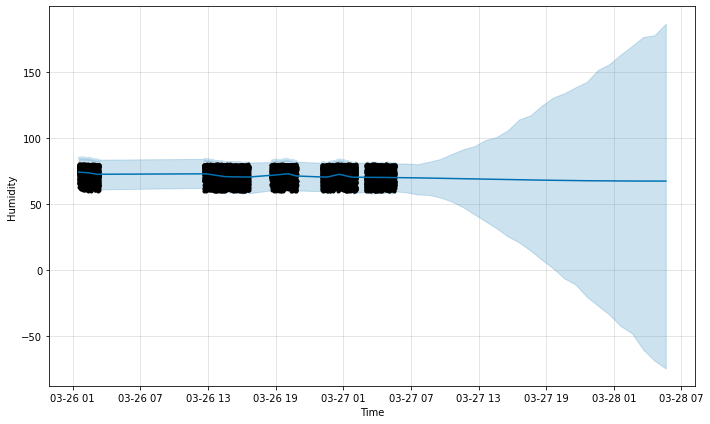

In [0]:
predict_fig = model.plot(forecast_pd, xlabel='Time', ylabel='Humidity')
display(predict_fig)

The dark blue line is predicted reading and the light blue shade is the 95% uncertainty interval. Because the data is randomly generated, the forcasted result itself doesn't make any sense.